In [1]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
from playground.SyncMatch.syncmatch.models.correspondence import get_correspondences_ratio_test
from playground.SyncMatch.syncmatch.utils.util import get_grid
import numpy as np
import cv2
from matplotlib import pyplot as plt
from utils.ploting_utils import plot_matches

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Unable to import SuperGlue. Please check docs/evaluation for instructions.
Unable to import LoFTR. Please check docs/evaluation for instructions.


In [6]:
from models.dino_v1 import ViTExtractor as DinoV1ExtractFeatures

In [ ]:
dino_model = DinoV1ExtractFeatures('vits8', 4, device="cuda")

In [2]:

def nn_gather(points, indices):
    # expand indices to same dimensions as points
    indices = indices[:, :, None]
    indices = indices.expand(-1, -1, points.shape[2])
    return points.gather(1, indices)

def get_keypoints(feat):

    shape = feat.shape
    grid = get_grid(shape[2],shape[3])
    grid = grid.to(feat)
    grid = grid.unsqueeze(0).repeat(shape[0],1,1,1)
    flat_grid = grid.flatten(2)
    return flat_grid[:,:2,:].permute(0,2,1)
    

In [3]:
processor = ViTImageProcessor.from_pretrained('facebook/dino-vits8')
model = ViTModel.from_pretrained('facebook/dino-vits8')

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
night_img_path = '/home/madhu/code/feature-slam/git_repos/dtd/img0.png'
day_img_path = '/home/madhu/code/feature-slam/git_repos/dtd/img1.png'
night_image = Image.open(night_img_path)
night_image = night_image.convert('RGB')

day_image = Image.open(day_img_path)
day_image = day_image.convert('RGB')
inputs = processor(images=[night_image,day_image], return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
hidden_states = last_hidden_states[:,1:]
hidden_states = hidden_states.permute(0,2,1).contiguous().view(-1, 384, 28,28)



(-0.5, 27.5, 27.5, -0.5)

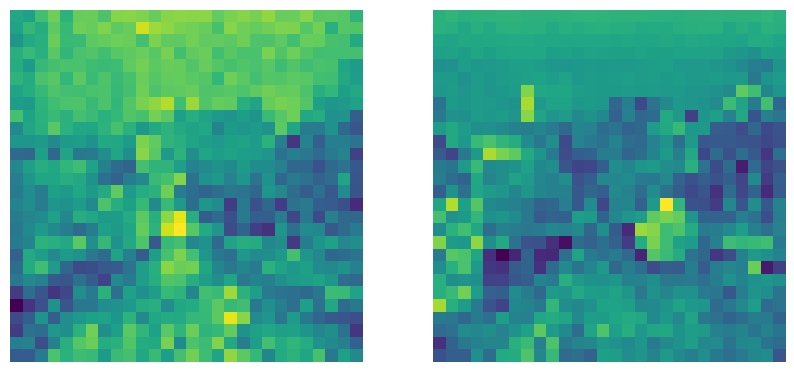

In [5]:
from matplotlib import pyplot as plt
day_feat = hidden_states[0].detach().cpu().numpy()
night_feat = hidden_states[1].detach().cpu().numpy()

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(day_feat[0])
ax[1].imshow(night_feat[0])
ax[0].axis('off')
ax[1].axis('off')


torch.Size([2, 384, 28, 28])
(224, 224, 3) (224, 224, 3) (1, 32, 2) (1, 32, 2)


(-0.5, 447.5, 223.5, -0.5)

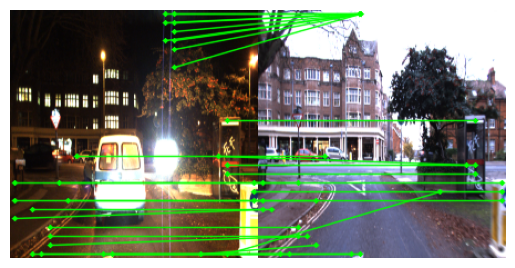

In [5]:
night_img_path = '/home/madhu/code/feature-slam/datasets/robotcar/img0.png'
day_img_path = '/home/madhu/code/feature-slam/datasets/robotcar/img1.png'
night_image = Image.open(night_img_path)
night_image = night_image.convert('RGB')

day_image = Image.open(day_img_path)
day_image = day_image.convert('RGB')

inputs = processor(images=[night_image,day_image], return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
hidden_states = last_hidden_states[:,1:]
hidden_states = hidden_states.permute(0,2,1).contiguous().view(-1, 384, 28,28)
print(hidden_states.shape)
night_feat = hidden_states[:1]
day_feat = hidden_states[1:]

idx0, idx1, weights = get_correspondences_ratio_test(night_feat,
                                                    day_feat,
                                                    32, 
                                                    )

kpts = get_keypoints(night_feat)
kpts0 = nn_gather(kpts * 8.0, idx0)
kpts1 = nn_gather(kpts * 8.0, idx1)


img0 = np.array(night_image)
re_img0 = cv2.resize(img0, (224,224))

img1 = np.array(day_image)
re_img1 = cv2.resize(img1, (224,224))

np_kpts0 = kpts0.detach().cpu().numpy()
np_kpts1 = kpts1.detach().cpu().numpy()

print(re_img0.shape, re_img1.shape, np_kpts0.shape, np_kpts1.shape)

out = plot_matches(re_img0, re_img1, np_kpts0[0], np_kpts1[0], layout = 'lr')

plt.imshow(out)
plt.axis('off')


In [41]:
weights

tensor([[0.4481, 0.3924, 0.3581, 0.3175, 0.3062, 0.2989, 0.2760, 0.2707, 0.2690,
         0.2680, 0.2676, 0.2666, 0.2625, 0.2543, 0.2525, 0.2419, 0.2394, 0.2379,
         0.2357, 0.2329, 0.2327, 0.2279, 0.2262, 0.2241, 0.2193, 0.2191, 0.2188,
         0.2184, 0.2123, 0.2110, 0.2091, 0.2088]], grad_fn=<SqueezeBackward1>)